# Sirviendo un modelo mediante TensorFlow Serve

En este ejemplo vamos a deplegar un modelo recién entrenado (eso sí, sin optimizar ni podas) a través de TensorFlow Serving.

Comenzaremos importando las librerías que usaremos.

In [1]:
import json
import os
import random
import subprocess
import tempfile
from pathlib import Path

import numpy as np
import requests
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (4, 2.25),'figure.dpi': 200})

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

También declararemos las constantes en las que se apoyan los ejemplos

In [3]:
EPOCHS = 2
REST_API_PORT = 6789

## Dataset

Vamos a usar MNIST como conjunto de datos. De acuerdo, a estas alturas no es ninguna sorpresa, pero ya conocemos su estructura y nos viene muy bien para ejemplos.

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train, X_test = X_train / 255, X_test / 255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

## Preparación del modelo a servir

Como no nos vamos a centrar en trabajar con el modelo, vamos a crear una CNN sencillita que resuelva más o menos bien el problema.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

model.fit(X_train, y_train, epochs=EPOCHS)

loss, acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {acc}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                54090     
Total params: 54,170
Trainable params: 54,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2672 - accuracy: 0.9237
Epoch 2/2
313/313 [==============================] - 0s 913us/step - loss: 0.0832 - accuracy: 0.9740
Test accuracy: 0.9739999771118164


Recordemos que, para poder servir nuestro a través de TensorFlow Serving, primero es neceario salvarlo en formato [SavedModel](https://www.tensorflow.org/guide/saved_model). Esto nos creará un archivo en formato ProtoBuf dentro de una jerarquía de directorios bien definida.

Nosotros especificaremos la versión. Cada nueva versión se exportará a un subdirectorio diferente bajo la ruta dada y desde TensorFlow Serving se podrá acceder a cualquiera de estas versiones (aunque por defecto se usará la más nueva).

In [6]:
MODEL_DIR = Path(tempfile.gettempdir())
version = 1
export_path = MODEL_DIR / str(version)
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print(f'Saved model in {export_path}; contents:')
!ls -l {export_path}

export_path = /tmp/1



2021-10-31 22:35:00.842754: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/1/assets
Saved model in /tmp/1; contents:
total 92
drwxr-xr-x 2 blazaid blazaid  4096 oct 31 22:34 assets
-rw-rw-r-- 1 blazaid blazaid  8060 oct 31 22:35 keras_metadata.pb
-rw-rw-r-- 1 blazaid blazaid 75461 oct 31 22:35 saved_model.pb
drwxr-xr-x 2 blazaid blazaid  4096 oct 31 22:35 variables


## Servir el modelo

El primer paso es instalar TensorFlow Service. Existen difeerntes formas para instalar, incluidos contenedores de docker. Nosotros, en nuestro caso, usaremos la herramienta `apt`, dando de alta previamente el repositorio de paquetes de la herraemienta. Para ello, basta con ejecutar desde el terminal:

```bash
$ echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list
$ curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -
$ sudo apt update
$ sudo apt install -y tensorflow-model-server
```

Una vez instalado, arrancaremos TensorFlow Serving y cargaremos nuestro modelo. Después de que se cargue podemos empezar a hacer peticiones de inferencia usando el protocolo REST. Los parámetros más relevantes para levantar el servidor son los siguientes:

* `rest_api_port`: El puerto que usaremos para hacer las peticiones REST
* `model_name`: El nombre del modelo, que se usará en la URL de las peticiones (puede ser cualquier cosa, no necesariamente el nombre del modelo ni nada por el estilo)
* `model_base_path`: La ruta del directorio donde está guardado el modelo (sin incluir las versiones)

Antes de arrancarlo, la variable de entorno `MODEL_DIR` tiene que estar establecida, además de ser especificada en el comando de arranque del modelo. 

In [7]:
os.environ["MODEL_DIR"] = str(MODEL_DIR)

Arrancamos con nohup para que funcione en segundo plano.

In [8]:
%%bash --bg 
tensorflow_model_server \
  --rest_api_port=6789 \
  --model_name=super_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [9]:
!tail server.log

## Haciendo peticiones al API

Vamos a crear primero una función para mostrar ejemplos de números por pantalla

In [10]:
def show(image, title):
    plt.figure()
    plt.imshow(image.reshape(28,28))
    plt.axis('off')
    plt.title(title)

Ahora, cojamos uno de los ejemplos del conjunto y veamos de cual se trata

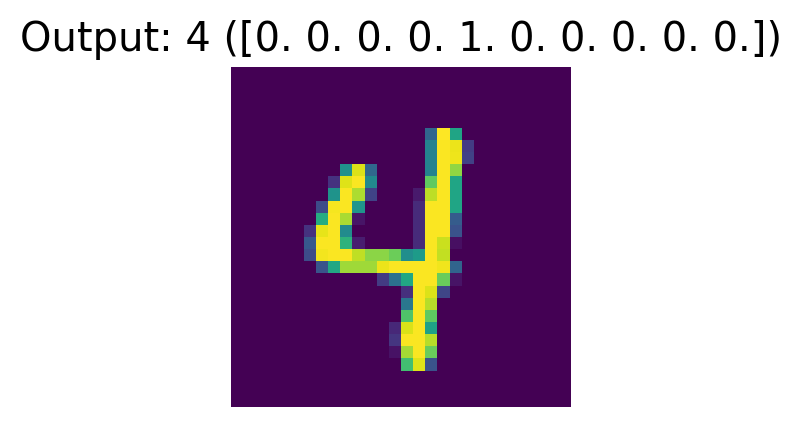

In [11]:
index = random.randint(0,len(X_test)-1)
sample_image = X_test[index]
sample_label = y_test[index]

show(sample_image, f'Output: {np.argmax(sample_label)} ({sample_label})')

Bien, como humano cuesta, pero como máquina será facilito.

### Petición a la última versión del API

Ahora lo que haremos será crear un batch de 5 imágenes aleatorias en un json para hacer la petición al servicio de predicción.

In [12]:
indices = np.random.choice(X_test.shape[0], 5)
X_test_batch = X_test[indices]
y_test_batch = y_test[indices]

print(f'Chosen indices from test: {indices}')

Chosen indices from test: [3653 7511  385 6107 6903]


Enviaremos un POST de predición al endpoint REST de nuestro servidor pasándole los 5 ejemplos elegidos de antes. El servidor, al no especificarle la versión de nuestro modelo, devolverá por defecto la última.

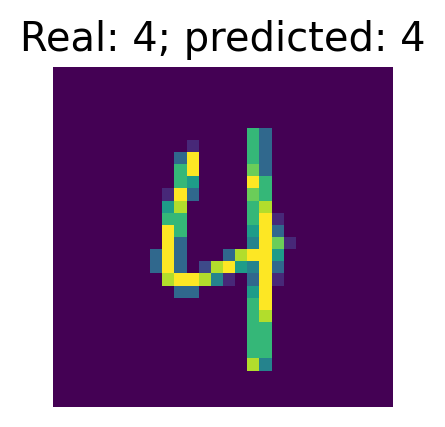

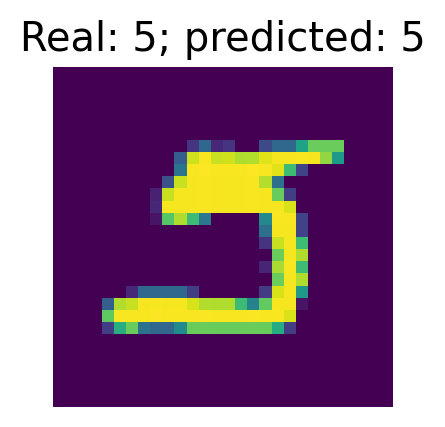

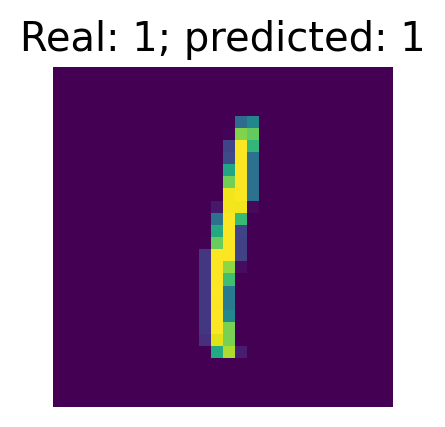

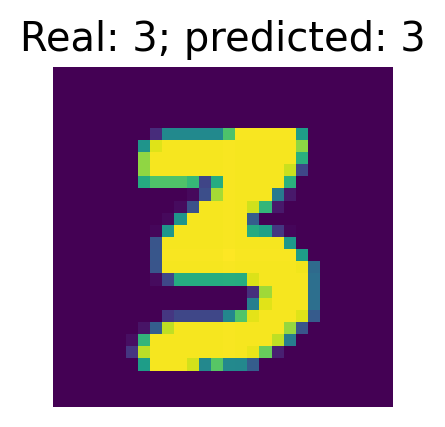

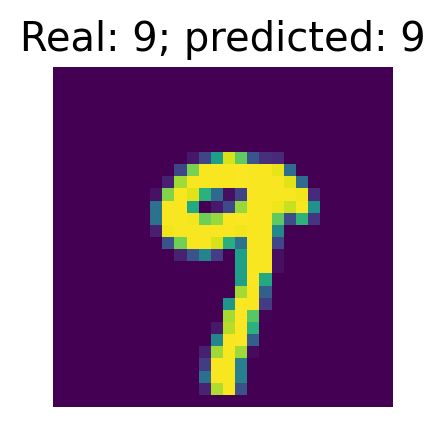

In [13]:
headers = {'content-type': 'application/json'}
response = requests.post(
    f'http://localhost:{REST_API_PORT}/v1/models/super_model:predict',
    json={'signature_name': 'serving_default', 'instances': X_test_batch.tolist()},
    headers={'content-type': 'application/json'}
)
predictions = json.loads(response.text)['predictions']

for X, y_real, y_pred in zip(X_test_batch, y_test_batch, predictions):
    show(X, f'Real: {np.argmax(y_real)}; predicted: {np.argmax(y_pred)}')

### Petición a una versión concreta del modelo servido

En este caso tenemos que especificar la versión que hemos especificado en la creación. Por lo demás, la petición es exactamente igual.

Chosen indices from test: [9518 9787 6427  274 6999]


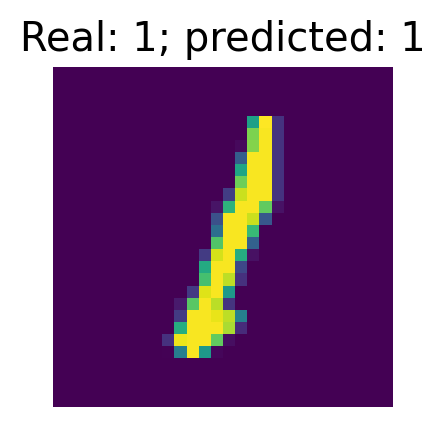

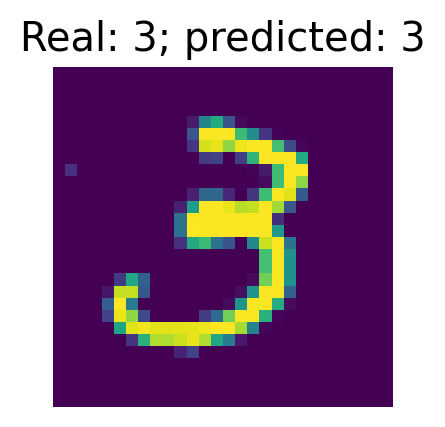

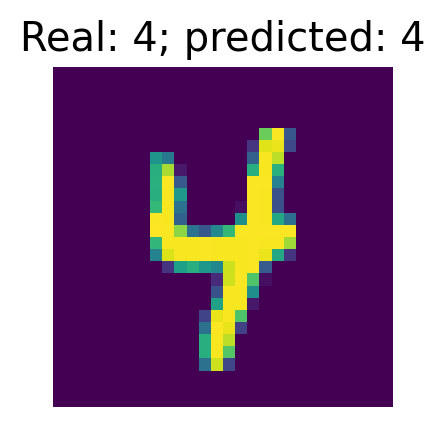

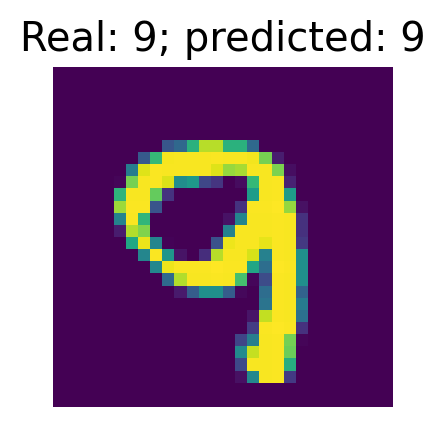

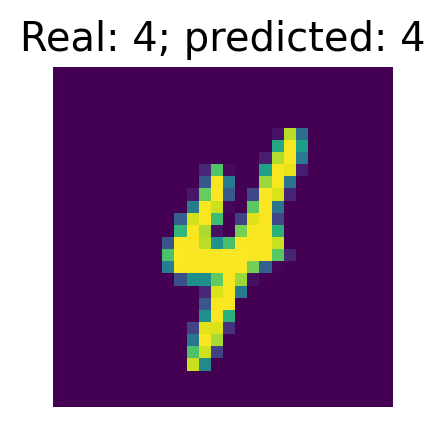

In [14]:
indices = np.random.choice(X_test.shape[0], 5)
X_test_batch = X_test[indices]
y_test_batch = y_test[indices]

print(f'Chosen indices from test: {indices}')

headers = {'content-type': 'application/json'}
response = requests.post(
    f'http://localhost:{REST_API_PORT}/v1/models/super_model:predict',
    json={'signature_name': 'serving_default', 'instances': X_test_batch.tolist()},
    headers={'content-type': 'application/json'}
)
predictions = json.loads(response.text)['predictions']

for X, y_real, y_pred in zip(X_test_batch, y_test_batch, predictions):
    show(X, f'Real: {np.argmax(y_real)}; predicted: {np.argmax(y_pred)}')